# Recolorization
The purpose of the project is to add colors to a grayscale image, knowing the mean intensity of red, green and blue in the expected image.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
import tensorflow as tf
import tensorflow_datasets as tfds

We work on the oxford flower dataset

In [ ]:
def load_flowers_dataset(num_samples=1000, img_size=128):
    ds = tfds.load('oxford_flowers102', split='train', shuffle_files=True)
    ds = ds.map(lambda x: tf.image.resize(x['image'], (img_size, img_size)) / 255.0)
    ds = ds.take(num_samples).batch(num_samples)
    images = next(iter(ds)).numpy()
    return images

In [ ]:
# === CONFIGURATION ===
IMG_SIZE = 128

Let us slightly reduce the resolution

In [ ]:
def preprocess_image(sample):
    """Resize and normalize image"""
    image = tf.image.resize(sample['image'], (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image

Here is a simple generator. Feel free to adapt it to your needs. Preserve the logic and structure for the test phase.


In [ ]:
# === DATA GENERATOR ===
class GrayScaleGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, batch_size=32, shuffle=True):
        self.images = images.numpy() # Convert to numpy array
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(images))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return len(self.images) // self.batch_size

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_color = self.images[batch_indices]
        batch_gray = np.mean(batch_color,axis=-1)
        batch_palette = np.mean(batch_color,axis=(1,2)) # batch of color palettes
        return (batch_gray, batch_palette), batch_color

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [ ]:
# === LOAD & SPLIT FLOWER DATA ===
def load_flower_dataset_splits():
    ds_train = tfds.load('oxford_flowers102', split='test', shuffle_files=True)
    ds_val = tfds.load('oxford_flowers102', split='validation', shuffle_files=True)
    ds_test = tfds.load('oxford_flowers102', split='train', shuffle_files=True)
    ds_train = tf.stack(list(ds_train.map(preprocess_image)))
    ds_val = tf.stack(list(ds_val.map(preprocess_image)))
    ds_test = tf.stack(list(ds_test.map(preprocess_image)))
    return (ds_train,ds_val,ds_test)

In [ ]:
train_imgs, val_imgs, test_imgs = load_flower_dataset_splits()

train_gen = GrayScaleGenerator(train_imgs, batch_size=32)
val_gen = GrayScaleGenerator(val_imgs, batch_size=32)
test_gen = GrayScaleGenerator(test_imgs, batch_size=32)

We define a simple baseline, where we uniformly distribute colors according to the given input palette.

In [ ]:
def baseline(gray,palette):
  m = np.mean(gray, axis=(1,2))
  red = gray*(palette[:,0]/m)[:, np.newaxis, np.newaxis]
  green = gray*(palette[:,1]/m)[:, np.newaxis, np.newaxis]
  blue = gray*(palette[:,2]/m)[:, np.newaxis, np.newaxis]
  return np.stack([red,green,blue],axis=-1)

Let us visualize a few examples.

(32, 128, 128) (32, 3) (32, 128, 128, 3)


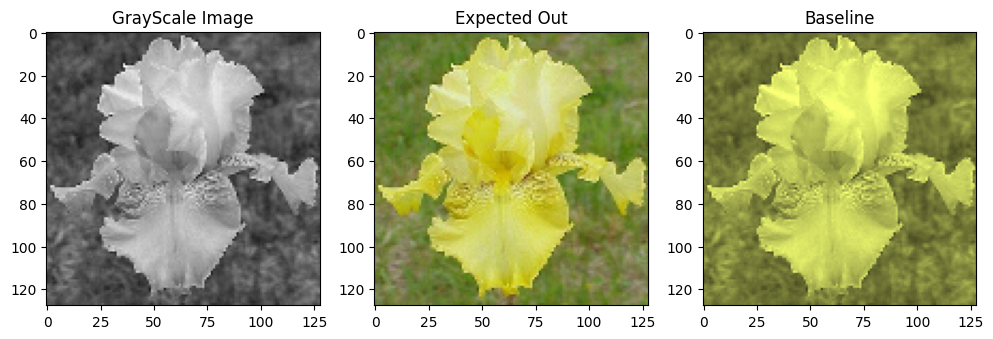

In [ ]:
# Sanity check
idx = np.random.randint(0, len(test_gen) - 1)
(x_gray,x_palette), y = test_gen[idx]
baseline_out = baseline(x_gray,x_palette)
print(x_gray.shape, x_palette.shape, y.shape)

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(x_gray[0],cmap='gray')
plt.title("GrayScale Image")

plt.subplot(1, 3, 2)
plt.imshow(y[0])
plt.title("Expected Out")

plt.subplot(1, 3, 3)
plt.imshow(baseline_out[0])
plt.title("Baseline")
plt.show()


Your objective is to improve over the baseline.

Let us compute the error of the baseline on a batch of data.

In [ ]:
idx = np.random.randint(0, len(test_gen) - 1)
(x_gray,x_palette), y = test_gen[idx]
baseline_out = baseline(x_gray,x_palette)
baseline_mse_batch = np.mean((baseline_out - y)**2,axis=(1,2))
baseline_mse = np.mean(baseline_mse_batch)
print(f"Baseline MSE: {baseline_mse:.4f}")

Baseline MSE: 0.0113


# Evaluation metric


The baseline error is already quite low. To better emphasize the correction we compute the ratio between the resulting error and the baseline one.
**This should be a value between 0 (perfect reconstruction) and 1 (no reconstruction). Higher values mean you are doing things worse.**

In [ ]:
# Predict the repaired images
#replace mock_model with your model
def mock_model(xin):
  x_gray,x_palette = xin
  return baseline(x_gray,x_palette)

#generated_images = your_model.predict([x_gray, x_palette])
generated_images = mock_model([x_gray, x_palette])

# Compute the distance between generated image and original for the batch
generated_mes_batch = np.mean((generated_images - y)**2,axis=(1,2))
# Now let us compute the ratio, and the average over the batch
mean_ratio = np.mean(generated_mes_batch/baseline_mse_batch)

print(f"Average score (Generated / Initial): {mean_ratio:.4f}")

Average score (Generated / Initial): 1.0000


In the previous case, since we used baseline as model, we get a score of 1.

**Repeat the previous computation for all batches in testing data, and return mean and standard deviation.**

# Parameters

Try to keep below 5M parameters (total, excluding parameteres of the optimizer).

You have the usual constraints:
* the project should be written in keras
* you should submit a single well documented notebook
* try to give access to weights through gdown


